In [ ]:
from transformers import BertModel, BertTokenizerFast
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from transformers import BertModel, BertTokenizerFast
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.multiclass import unique_labels
import pandas as pd
import numpy as np
import os
from transformers import BertModel, BertTokenizerFast, logging

In [ ]:
# Load datasets
train = pd.read_csv('/home/naamamai/Final_Project/train_10_intents.csv')
test_with_label = pd.read_csv('/home/naamamai/Final_Project/test_pilot_10_intents.csv')

# Create a new DataFrame without the 'label' column
test_without_label = test_with_label.drop(columns=['label'])

In [ ]:
le = LabelEncoder()
train['intent_num'] = le.fit_transform(train['intent'])
map_intent = dict(zip(le.transform(le.classes_), le.classes_))
map_intent

{0: 'alarm_set',
 1: 'calendar_set',
 2: 'call_contact',
 3: 'camera_query',
 4: 'iot_wemo_on',
 5: 'lists_createoradd',
 6: 'query',
 7: 'send_message',
 8: 'transport_query',
 9: 'weather_query'}

In [ ]:
input = list(train['transcript_hebrew'])

In [ ]:
from transformers import AutoTokenizer, AutoModel


In [ ]:
logging.set_verbosity_error()

# Load AlephBERT-gimel base model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("dicta-il/alephbertgimmel-base")
model = AutoModel.from_pretrained("dicta-il/alephbertgimmel-base")

# Tokenize and pad input
encoded_inputs = tokenizer(
    input,
    padding=True,
    truncation=True,
    return_tensors='pt'
)



In [ ]:
with torch.no_grad():
  outputs = model(**encoded_inputs)

In [ ]:
# the embedding of the first sentnce
outputs[0]

tensor([[[ 4.5445e-01,  7.5889e-01,  6.4955e-02,  ...,  8.7001e-01,
          -7.0923e-02, -3.0612e-01],
         [ 6.0408e-01, -2.0087e+00,  2.6066e-01,  ...,  2.5619e-01,
           2.8850e-01,  7.3943e-02],
         [ 1.0407e+00, -9.6727e-01,  6.5926e-01,  ...,  3.1241e-01,
          -5.0820e-02, -8.9930e-02],
         ...,
         [-2.0263e-01, -1.7840e-01, -2.3613e-01,  ...,  9.5665e-01,
          -1.6930e-01,  7.4622e-02],
         [ 3.6403e-01, -1.8056e+00, -1.3483e-01,  ...,  2.9382e-01,
           1.7120e-01, -3.9202e-01],
         [-3.1073e-02, -1.0352e+00, -8.5365e-02,  ...,  2.9896e-01,
          -7.9301e-02, -2.4298e-01]],

        [[ 1.0331e+00,  1.5933e+00,  1.0194e-01,  ..., -1.1114e-01,
           1.4071e-01, -1.5685e-01],
         [ 9.3601e-01, -8.0193e-01, -1.5901e-01,  ...,  2.1037e+00,
           6.1985e-01,  2.3296e-03],
         [-5.5160e-01,  5.7285e-01,  1.1261e-01,  ...,  4.2669e-01,
           3.8727e-01, -1.9730e-01],
         ...,
         [-8.3012e-02,  6

In [ ]:
token_embeddings = outputs.last_hidden_state

In [ ]:
sentence_embeddings = []
for embedding in token_embeddings:
  sentence_embeddings.append(embedding.flatten().numpy())

In [ ]:
sentence_embeddings = np.array(sentence_embeddings)

In [ ]:
labels = list(train['intent_num'])

In [ ]:
input_test = list(test_without_label['transcript_hebrew'])
encoded_inputs_test = tokenizer(input_test, padding=True,
                            truncation=True,
                            return_tensors='pt')
with torch.no_grad():
  outputs_test = model(**encoded_inputs_test)

token_embeddings_test = outputs_test.last_hidden_state
sentence_embeddings_test = []
for embedding in token_embeddings_test:
    sentence_embeddings_test.append(embedding.flatten().numpy())

sentence_embeddings_test = np.array(sentence_embeddings_test)

intent_to_num = {v: k for k, v in map_intent.items()}

# Map the 'intent' column in the test data to 'intent_num'
test_without_label['intent_num'] = test_without_label['intent'].map(intent_to_num)

# Check the result
print(test_without_label[['intent', 'intent_num']].head())

labels_test = list(test_without_label['intent_num'])

print(labels_test)
test_without_label



            intent  intent_num
0  transport_query           8
1     call_contact           2
2        alarm_set           0
3     send_message           7
4            query           6
[8, 2, 0, 7, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 0, 3, 3, 3, 3, 3, 3, 9, 5, 4, 4, 8, 8, 2, 2, 0, 7, 7, 7, 7, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 1, 0, 0, 0, 0, 3, 3, 9, 5, 5, 4, 4, 8, 8, 8, 8, 2, 2, 0, 7, 6, 6, 8, 8, 1, 0, 3, 3, 3, 3, 3, 9, 5, 5, 5, 5, 5, 4, 4, 8, 2, 2, 0, 7, 6, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 3, 9, 9, 5, 4, 4, 4]


,transcript_hebrew,intent,intent_num
0,היי סירי את יכולה למצוא לי מסלול מהמיקום שלי ...,transport_query,8
1,היי סירי את יכולה לחייג לקורל יגוד,call_contact,2
2,היי סירי את יכולה לכוון שעון מעורר לשמונה וחצ...,alarm_set,0
3,היי סירי את יכולה לשלוח הודעה לקורל יגוד,send_message,7
4,היי סירי את יכולה לחפש לי מתכון לעוגה באסקית,query,6
...,...,...,...
104,למה את לא עונה לי אני רוצה לדעת אם בתל אביב יר...,weather_query,9
105,אני רוצה לרשום קניות חלב וביצים אם תוכלי לעזור לי,lists_createoradd,5
106,כי אני רוצה להפעיל מצב טיסה,iot_wemo_on,4
107,אני רוצה להפעיל מצב טיסה בסדר,iot_wemo_on,4


In [ ]:
# Convert labels and labels_test to pandas Series
labels_series = pd.Series(labels)
labels_test_series = pd.Series(labels_test)

# Concatenate the Series objects
final_labels = pd.concat([labels_series, labels_test_series], ignore_index=True)
print(len(final_labels))

# Ensure the labels match the total embeddings (train + test split already done)
assert len(final_labels) == len(sentence_embeddings) + len(sentence_embeddings_test), "Labels must match embeddings."

# Split labels to create y_train and y_test
y_train = labels
y_test = labels_test

# Assign embeddings to X_train and X_test
X_train = sentence_embeddings
X_test = sentence_embeddings_test

# Check the shapes to ensure correct splitting
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

6389
X_train shape: (6280, 19200)
X_test shape: (109, 15360)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Ensure consistent dimensions between X_train and X_test
if X_train.shape[1] != X_test.shape[1]:
    print("Aligning features...")
    # Example: Truncate or pad X_test to match X_train's feature size
    if X_train.shape[1] > X_test.shape[1]:
        diff = X_train.shape[1] - X_test.shape[1]
        X_test = np.pad(X_test, ((0, 0), (0, diff)), mode='constant')
    elif X_train.shape[1] < X_test.shape[1]:
        X_test = X_test[:, :X_train.shape[1]]

# Verify shapes
print(f"Updated X_train shape: {X_train.shape}")
print(f"Updated X_test shape: {X_test.shape}")
print(X_test[:5])
print(y_test[:5])


Aligning features...
Updated X_train shape: (6280, 19200)
Updated X_test shape: (109, 19200)
[[ 1.5155003  -0.11384504 -0.05450333 ...  0.          0.
   0.        ]
 [ 1.9759762   0.30239424  0.12144632 ...  0.          0.
   0.        ]
 [ 1.2356203   0.33252725 -0.02211865 ...  0.          0.
   0.        ]
 [ 1.9613148   0.1990213   0.04883408 ...  0.          0.
   0.        ]
 [ 1.44945     0.6195833  -0.27884677 ...  0.          0.
   0.        ]]
[8, 2, 0, 7, 6]


transfer learning with fine-tuning using a pre-trained BERT model (onlplab/alephbert-gimel-base)

חיפוש גרידי - מציאת פרמטרים טובים ביותר:

In [ ]:
import os
import copy
import warnings
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score


from torch.utils.data import DataLoader, TensorDataset
from transformers import BertModel, BertTokenizerFast, AdamW
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import copy


In [ ]:
warnings.filterwarnings("ignore")

class BertForIntentClassification(torch.nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BertForIntentClassification, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(bert_model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

In [ ]:
def run_grid_search(encoded_inputs, labels, encoded_inputs_test, labels_test, map_intent, base_bert_model):
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    from transformers import AdamW
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    import copy

    learning_rates = [5e-5, 2e-5, 1e-5]
    batch_sizes = [16, 32, 64]
    num_classes = len(map_intent)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    best_val_loss = float('inf')
    best_model_path = ""
    best_metrics = {}
    best_bs = None
    experiment_results = {lr: {} for lr in learning_rates}

    best_train_losses, best_val_losses = [], []
    best_train_accuracies, best_val_accuracies = [], []

    for lr in learning_rates:
        for bs in batch_sizes:
            print(f"\n🔧 Training with LR={lr}, BS={bs}")

            model = BertForIntentClassification(copy.deepcopy(base_bert_model), num_classes).to(device)
            optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
            criterion = nn.CrossEntropyLoss()

            train_dataset = TensorDataset(
                torch.tensor(encoded_inputs['input_ids'], dtype=torch.long),
                torch.tensor(encoded_inputs['attention_mask'], dtype=torch.long),
                torch.tensor(labels, dtype=torch.long))

            test_dataset = TensorDataset(
                torch.tensor(encoded_inputs_test['input_ids'], dtype=torch.long),
                torch.tensor(encoded_inputs_test['attention_mask'], dtype=torch.long),
                torch.tensor(labels_test, dtype=torch.long))

            train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

            epochs = 15
            patience = 3
            best_loss = float('inf')
            early_stop_counter = 0

            train_losses, val_losses = [], []
            train_accuracies, val_accuracies = [], []

            for epoch in range(epochs):
                model.train()
                total_loss, correct_train, total_train = 0, 0, 0

                for batch in train_loader:
                    input_ids, attention_mask, y = [b.to(device) for b in batch]
                    optimizer.zero_grad()
                    outputs = model(input_ids, attention_mask)
                    loss = criterion(outputs, y)
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()
                    preds = torch.argmax(outputs, dim=1)
                    correct_train += (preds == y).sum().item()
                    total_train += y.size(0)

                avg_train_loss = total_loss / len(train_loader)
                train_accuracy = correct_train / total_train

                model.eval()
                val_loss, correct_val, total_val = 0, 0, 0
                all_preds, all_labels = [], []

                with torch.no_grad():
                    for batch in test_loader:
                        input_ids, attention_mask, y = [b.to(device) for b in batch]
                        outputs = model(input_ids, attention_mask)
                        loss = criterion(outputs, y)
                        val_loss += loss.item()
                        preds = torch.argmax(outputs, dim=1)
                        correct_val += (preds == y).sum().item()
                        total_val += y.size(0)
                        all_preds.extend(preds.cpu().numpy())
                        all_labels.extend(y.cpu().numpy())

                avg_val_loss = val_loss / len(test_loader)
                val_accuracy = correct_val / total_val
                macro_f1 = f1_score(all_labels, all_preds, average="macro")

                train_losses.append(avg_train_loss)
                val_losses.append(avg_val_loss)
                train_accuracies.append(train_accuracy)
                val_accuracies.append(val_accuracy)

                print(f"Epoch {epoch+1:>2}, Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.4f}, "
                      f"Val Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.4f}, F1: {macro_f1:.4f}")

                if avg_val_loss < best_loss:
                    best_loss = avg_val_loss
                    early_stop_counter = 0

                    if best_loss < best_val_loss:
                        best_val_loss = best_loss
                        best_model_path = "best_model_final.pt"
                        best_bs = bs
                        torch.save(model.state_dict(), best_model_path)

                        best_train_losses = train_losses.copy()
                        best_val_losses = val_losses.copy()
                        best_train_accuracies = train_accuracies.copy()
                        best_val_accuracies = val_accuracies.copy()

                        best_metrics = {
                            "lr": lr,
                            "bs": bs,
                            "f1_per_intent": classification_report(all_labels, all_preds, target_names=list(map_intent.values()), output_dict=True),
                            "confusion_matrix": confusion_matrix(all_labels, all_preds),
                        }

                else:
                    early_stop_counter += 1
                    print(f"   ⏳ No improvement. Patience left: {patience - early_stop_counter}")

                if early_stop_counter >= patience:
                    print("   🚨 Early stopping due to patience exhaustion.")
                    break
                elif train_accuracy > 0.99 and early_stop_counter >= 1:
                    print("   🔁 Early stopping due to overfitting.")
                    break

            experiment_results[lr][bs] = avg_val_loss
            del model
            torch.cuda.empty_cache()

    print(f"\n✅ Best model saved at: {best_model_path} (Batch Size: {best_bs})")

    print(f"📌 Best LR: {best_metrics.get('lr')}, BS: {best_bs}, Best Val Loss: {best_val_loss:.4f}")


    # === Plot graphs only if we have data
    if best_train_losses:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(best_train_losses, label="Training Loss")
        plt.plot(best_val_losses, label="Validation Loss")
        plt.title(f"Loss (LR={best_metrics['lr']}, BS={best_metrics['bs']})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(best_train_accuracies, label="Training Accuracy")
        plt.plot(best_val_accuracies, label="Validation Accuracy")
        plt.title(f"Accuracy (LR={best_metrics['lr']}, BS={best_metrics['bs']})")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # === F1 per intent
    f1_report = best_metrics["f1_per_intent"]
    f1_scores = [f1_report[label]["f1-score"] for label in map_intent.values()]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(map_intent.values()), y=f1_scores)
    plt.xticks(rotation=45)
    plt.title("F1 Score per Intent")
    plt.ylabel("F1-score")
    plt.tight_layout()
    plt.show()

    # === Confusion Matrix
    cm = best_metrics["confusion_matrix"]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(map_intent.values()),
                yticklabels=list(map_intent.values()))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # === Grid Search Summary Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.25
    x = np.arange(len(learning_rates))
    colors = ['lightblue', 'lightpink', 'lightgreen']

    for i, bs in enumerate(batch_sizes):
        losses = [experiment_results[lr][bs] for lr in learning_rates]
        ax.bar(x + i * width, losses, width=width, label=f"Batch Size: {bs}", color=colors[i])

    ax.set_xlabel("Learning Rates")
    ax.set_ylabel("Validation Loss")
    ax.set_title("Validation Loss Comparison")
    ax.set_xticks(x + width)
    ax.set_xticklabels([str(lr) for lr in learning_rates])
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return best_model_path, best_bs



🔧 Training with LR=5e-05, BS=16
Epoch  1, Train Loss: 0.2346, Acc: 0.9389, Val Loss: 0.5640, Acc: 0.8807, F1: 0.8816
Epoch  2, Train Loss: 0.0125, Acc: 0.9976, Val Loss: 0.3652, Acc: 0.8899, F1: 0.8877
Epoch  3, Train Loss: 0.0041, Acc: 0.9994, Val Loss: 0.5624, Acc: 0.8899, F1: 0.8878
   ⏳ No improvement. Patience left: 2
   🔁 Early stopping due to overfitting.

🔧 Training with LR=5e-05, BS=32
Epoch  1, Train Loss: 0.3174, Acc: 0.9229, Val Loss: 0.9916, Acc: 0.8440, F1: 0.8465
Epoch  2, Train Loss: 0.0124, Acc: 0.9982, Val Loss: 1.0527, Acc: 0.8716, F1: 0.8739
   ⏳ No improvement. Patience left: 2
   🔁 Early stopping due to overfitting.

🔧 Training with LR=5e-05, BS=64
Epoch  1, Train Loss: 0.4754, Acc: 0.8809, Val Loss: 0.5353, Acc: 0.8807, F1: 0.8777
Epoch  2, Train Loss: 0.0153, Acc: 0.9986, Val Loss: 0.5907, Acc: 0.8807, F1: 0.8871
   ⏳ No improvement. Patience left: 2
   🔁 Early stopping due to overfitting.

🔧 Training with LR=2e-05, BS=16
Epoch  1, Train Loss: 0.4506, Acc: 0.88

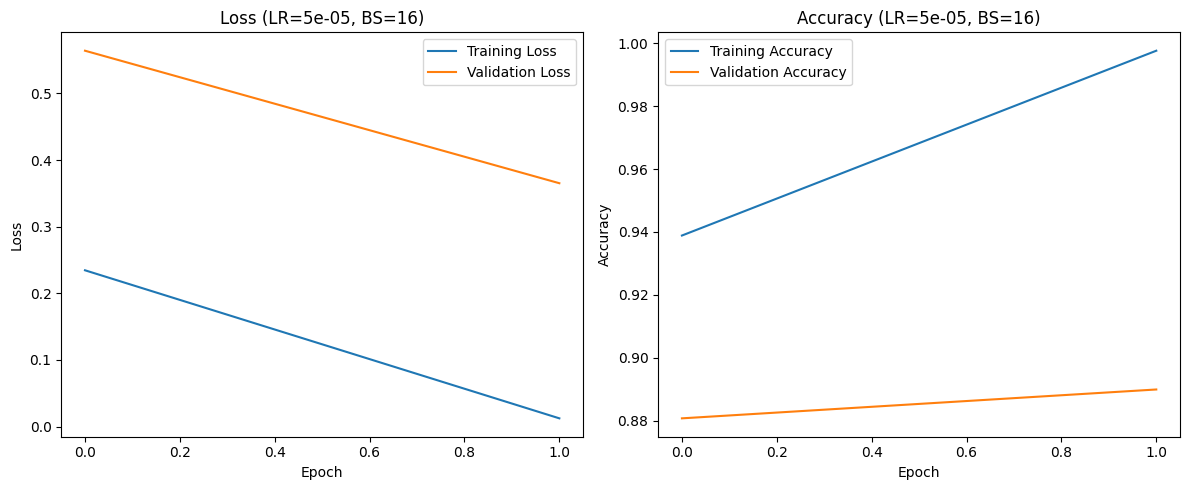

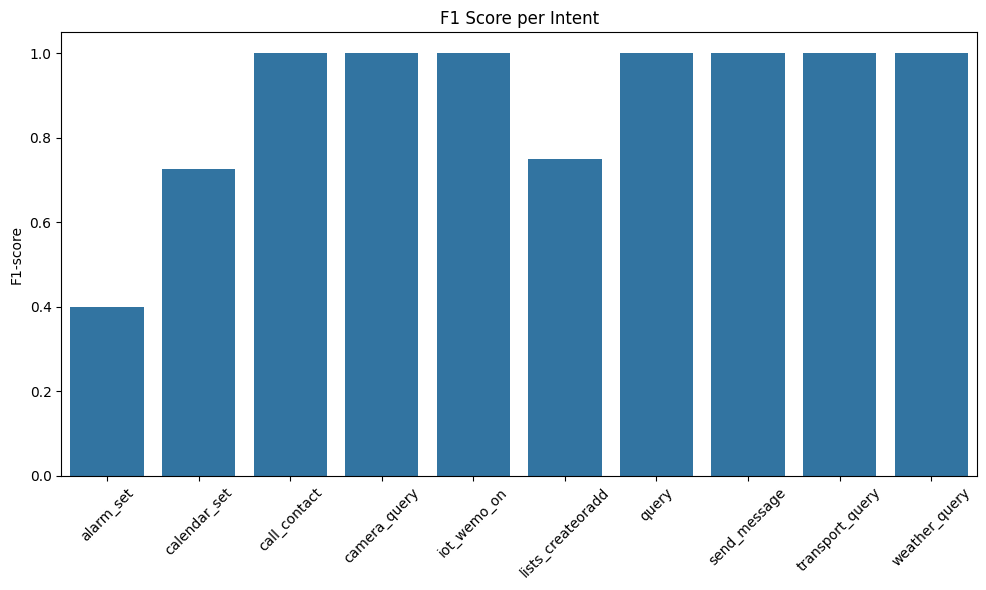

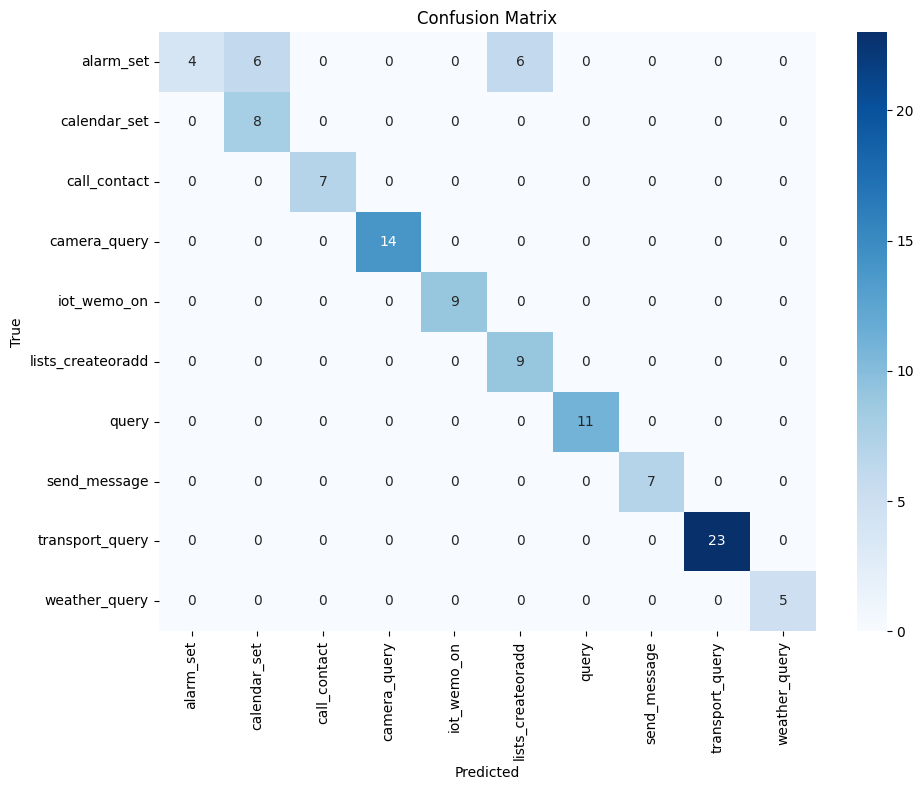

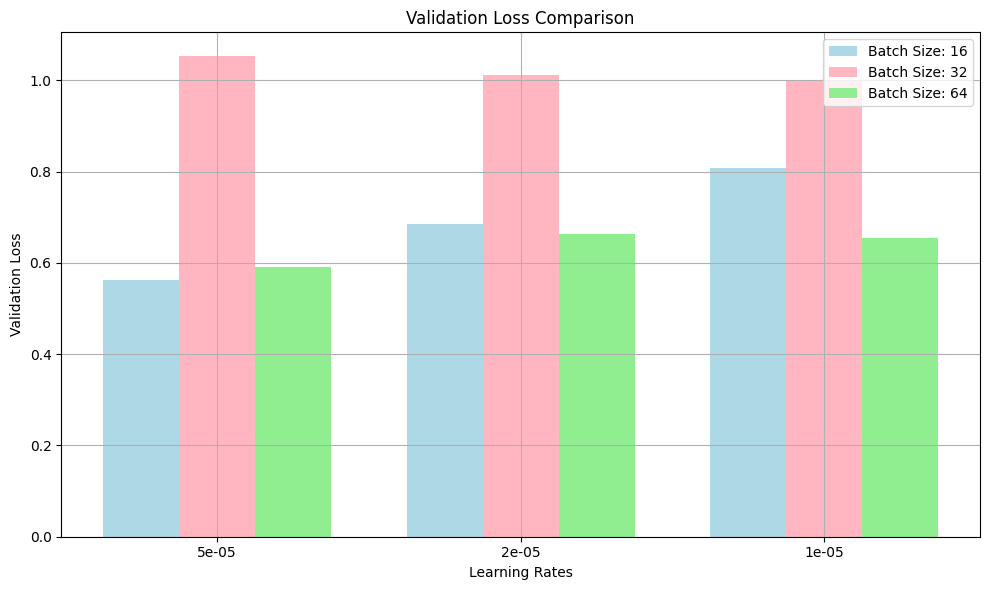

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

best_model_path, best_batch_size = run_grid_search(
    encoded_inputs,
    labels,
    encoded_inputs_test,
    labels_test,
    map_intent,
    model
)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
from sklearn.metrics import accuracy_score, classification_report
import copy


הערכה - Test

In [ ]:

def evaluate_best_model(encoded_inputs_test, labels_test, map_intent, base_bert_model, best_model_path, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    min_len_test = min(
        len(encoded_inputs_test['input_ids']),
        len(encoded_inputs_test['attention_mask']),
        len(labels_test)
    )

    input_ids_test_trimmed = encoded_inputs_test['input_ids'][:min_len_test]
    attention_mask_test_trimmed = encoded_inputs_test['attention_mask'][:min_len_test]
    labels_test_trimmed = labels_test[:min_len_test]

    test_dataset = TensorDataset(
        torch.tensor(input_ids_test_trimmed, dtype=torch.long),
        torch.tensor(attention_mask_test_trimmed, dtype=torch.long),
        torch.tensor(labels_test_trimmed, dtype=torch.long))

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    best_model = BertForIntentClassification(copy.deepcopy(base_bert_model), len(map_intent)).to(device)
    best_model.load_state_dict(torch.load(best_model_path))
    best_model.eval()

    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, y = [b.to(device) for b in batch]
            outputs = best_model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(y.cpu().numpy())

    from sklearn.utils.multiclass import unique_labels
    accuracy = accuracy_score(true_labels, predictions)
    print(f"\n✅ Final Test Accuracy: {accuracy * 100:.2f}%")

    present_classes = unique_labels(true_labels, predictions)
    present_class_names = [map_intent[i] for i in present_classes]

    print("\n📋 Final Classification Report:")
    print(classification_report(true_labels, predictions, target_names=present_class_names))

    # === Extract True Positive Examples ===
    true_positive_examples = {i: [] for i in map_intent.keys()}
    for i, (true, pred) in enumerate(zip(true_labels, predictions)):
        if true == pred:
            intent_name = map_intent[true]
            true_positive_examples[true].append(test_without_label.iloc[i]['transcript_hebrew'])

    # === Show Confusion Matrix ===
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=present_class_names,
                yticklabels=present_class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return true_labels, predictions, true_positive_examples



הדפסת תוצאות הערכה
ויצירת דאטה סט מה שלא זוהה על ידי סירי וזוהה על ידי המודל שלנו:



✅ Final Test Accuracy: 88.99%

📋 Final Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      0.25      0.40        16
     calendar_set       0.57      1.00      0.73         8
     call_contact       1.00      1.00      1.00         7
     camera_query       1.00      1.00      1.00        14
      iot_wemo_on       1.00      1.00      1.00         9
lists_createoradd       0.60      1.00      0.75         9
            query       1.00      1.00      1.00        11
     send_message       1.00      1.00      1.00         7
  transport_query       1.00      1.00      1.00        23
    weather_query       1.00      1.00      1.00         5

         accuracy                           0.89       109
        macro avg       0.92      0.93      0.89       109
     weighted avg       0.94      0.89      0.87       109



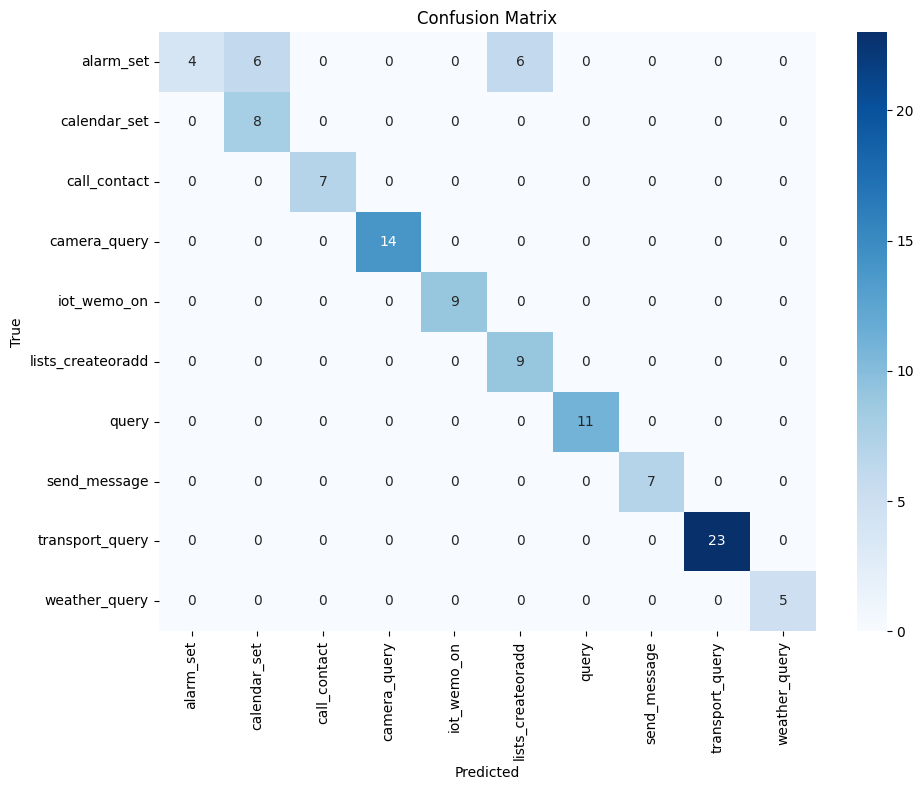

In [ ]:
# Filter true positives from test_with_label where label == 'no'
df_pilot_label = test_with_label

# Create a list to collect the final filtered rows
new_cv_rows = []

true_labels, predictions, true_positive_examples = evaluate_best_model(
    encoded_inputs_test,
    labels_test,
    map_intent,
    model,
    best_model_path,
    best_batch_size
)



# Loop through true positives
for class_id, examples in true_positive_examples.items():
    for example in examples:
        # Filter the row from the original test DataFrame
        row = df_pilot_label[df_pilot_label['transcript_hebrew'] == example]
        if not row.empty and row.iloc[0]['label'] == 'no':
            new_cv_rows.append(row.iloc[0])

# Create the new CV DataFrame with only the desired columns
new_cv_df = pd.DataFrame(new_cv_rows)[['transcript_hebrew', 'intent']]

# Optionally save to CSV
new_cv_df.to_csv('true_positive_label_no.csv', index=False, encoding="utf-8-sig")


שימוש באינדקס - מחברת חדשה